In [9]:
import pandas as pd
import sqlite3

# Load the dataset
file_path = "C:/Users/SAI VIGNESH CHINTALA/Desktop/ML1/breast-cancer.csv"
breast_cancer_data = pd.read_csv(file_path)

# Create a new SQLite database (or connect to an existing one)
conn = sqlite3.connect('C:/Users/SAI VIGNESH CHINTALA/Desktop/ML1/breast_cancer.db')
cursor = conn.cursor()

# Define the SQL schema for Patient Information table
create_patient_info_table = """
CREATE TABLE IF NOT EXISTS PatientInformation (
    id INTEGER PRIMARY KEY,
    diagnosis TEXT
);
"""

# Define the SQL schema for Feature Statistics table
create_feature_stats_table = """
CREATE TABLE IF NOT EXISTS FeatureStatistics (
    id INTEGER,
    radius_mean REAL,
    texture_mean REAL,
    perimeter_mean REAL,
    area_mean REAL,
    smoothness_mean REAL,
    compactness_mean REAL,
    concavity_mean REAL,
    concave_points_mean REAL,
    symmetry_mean REAL,
    fractal_dimension_mean REAL,
    radius_se REAL,
    texture_se REAL,
    perimeter_se REAL,
    area_se REAL,
    smoothness_se REAL,
    compactness_se REAL,
    concavity_se REAL,
    concave_points_se REAL,
    symmetry_se REAL,
    fractal_dimension_se REAL,
    radius_worst REAL,
    texture_worst REAL,
    perimeter_worst REAL,
    area_worst REAL,
    smoothness_worst REAL,
    compactness_worst REAL,
    concavity_worst REAL,
    concave_points_worst REAL,
    symmetry_worst REAL,
    fractal_dimension_worst REAL,
    FOREIGN KEY (id) REFERENCES PatientInformation(id)
);
"""

# Execute the table creation queries
cursor.execute(create_patient_info_table)
cursor.execute(create_feature_stats_table)

# Commit changes
conn.commit()

# Insert data into the tables from the breast cancer dataset
patient_info_data = breast_cancer_data[['id', 'diagnosis']]
feature_stats_data = breast_cancer_data.drop(columns=['diagnosis'])

# Insert data into PatientInformation table
patient_info_data.to_sql('PatientInformation', conn, if_exists='replace', index=False)

# Insert data into FeatureStatistics table
feature_stats_data.to_sql('FeatureStatistics', conn, if_exists='replace', index=False)

# Add an index to improve query performance
cursor.execute("CREATE INDEX IF NOT EXISTS idx_patient_id ON FeatureStatistics(id);")
conn.commit()

# Close the database connection
conn.close()


In [11]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
db_path = 'C:/Users/SAI VIGNESH CHINTALA/Desktop/ML1/breast_cancer.db'
conn = sqlite3.connect(db_path)

# SQL query to join PatientInformation and FeatureStatistics tables
query = """
SELECT 
    PatientInformation.id, 
    PatientInformation.diagnosis, 
    FeatureStatistics.radius_mean, 
    FeatureStatistics.texture_mean, 
    FeatureStatistics.perimeter_mean, 
    FeatureStatistics.area_mean, 
    FeatureStatistics.smoothness_mean
FROM 
    PatientInformation
JOIN 
    FeatureStatistics
ON 
    PatientInformation.id = FeatureStatistics.id
"""

# Execute the query and load the result into a Pandas DataFrame
joined_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the first few rows of the DataFrame
print(joined_data.head())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  
0          0.11840  
1          0.08474  
2          0.10960  
3          0.14250  
4          0.10030  


In [13]:
from sklearn.model_selection import train_test_split

# Assuming `data` is already loaded from Step 2
# data: Pandas DataFrame containing the joined dataset

# Check for missing values
print("Missing Values:\n", joined_data.isnull().sum())

# Check the distribution of the target variable (diagnosis)
print("\nDiagnosis Distribution:\n", joined_data['diagnosis'].value_counts())

# Convert diagnosis column to binary (e.g., M=1, B=0) for classification
joined_data['diagnosis'] = joined_data['diagnosis'].map({'M': 1, 'B': 0})

# Features (X) and target (y)
X = joined_data.drop(columns=['id', 'diagnosis'])
y = joined_data['diagnosis']

# Perform train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Display train/test split details
print("\nTrain/Test Split:")
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Missing Values:
 id                 0
diagnosis          0
radius_mean        0
texture_mean       0
perimeter_mean     0
area_mean          0
smoothness_mean    0
dtype: int64

Diagnosis Distribution:
 diagnosis
B    357
M    212
Name: count, dtype: int64

Train/Test Split:
Training set size: (455, 5)
Test set size: (114, 5)


In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Assuming `joined_data` is loaded and `diagnosis` is mapped to binary values (M=1, B=0)

# Step 4.1: Y-Profile Report using ydata-profiling
profile = ProfileReport(joined_data, title="Breast Cancer Dataset Profiling Report", explorative=True)
profile.to_file("breast_cancer_profile_report.html")
print("Y-Profile Report saved as 'breast_cancer_profile_report.html'")

# Step 4.2: Correlation Matrix
plt.figure(figsize=(12, 8))
correlation_matrix = joined_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Step 4.3: Distributions and Y-Profiles
selected_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']

# Boxplots for diagnosis vs features
for feature in selected_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=joined_data['diagnosis'], y=joined_data[feature], palette="Set2")
    plt.title(f"Y-Profile for {feature} (Diagnosis vs {feature})")
    plt.xlabel("Diagnosis (0=Benign, 1=Malignant)")
    plt.ylabel(feature)
    plt.show()

# Step 4.4: Missing Values and Cleanup Tasks
missing_values = joined_data.isnull().sum()
print("\nMissing Values:\n", missing_values)

cleanup_tasks = []

# Check for highly correlated features
high_corr_features = correlation_matrix[(correlation_matrix > 0.9) & (correlation_matrix != 1.0)].stack()
if not high_corr_features.empty:
    cleanup_tasks.append(f"Highly correlated features identified: {high_corr_features.index.tolist()}")

# Check for missing values
if missing_values.any():
    cleanup_tasks.append(f"Columns with missing values: {missing_values[missing_values > 0].index.tolist()}")

# Scaling for large ranges
if any(joined_data[selected_features].max() > 1000):
    cleanup_tasks.append("Feature scaling needed for columns with large ranges.")

print("\nCleanup Tasks:")
for task in cleanup_tasks:
    print(f"- {task}")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Y-Profile Report saved as 'breast_cancer_profile_report.html'


C:\Users\SAI VIGNESH CHINTALA\AppData\Local\Temp\ipykernel_23408\1381321699.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\SAI VIGNESH CHINTALA\AppData\Local\Temp\ipykernel_23408\1381321699.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=joined_data['diagnosis'], y=joined_data[feature], palette="Set2")
C:\Users\SAI VIGNESH CHINTALA\AppData\Local\Temp\ipykernel_23408\1381321699.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\SAI VIGNESH CHINTALA\AppData\Local\Temp\ipykernel_23408\1381321699.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=joined_data['diagnosis'], y=jo


Missing Values:
 id                 0
diagnosis          0
radius_mean        0
texture_mean       0
perimeter_mean     0
area_mean          0
smoothness_mean    0
dtype: int64

Cleanup Tasks:
- Highly correlated features identified: [('radius_mean', 'perimeter_mean'), ('radius_mean', 'area_mean'), ('perimeter_mean', 'radius_mean'), ('perimeter_mean', 'area_mean'), ('area_mean', 'radius_mean'), ('area_mean', 'perimeter_mean')]
- Feature scaling needed for columns with large ranges.


In [138]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'

mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Step 1: Preprocessing pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing step
    ('logistic', LogisticRegression(random_state=42, max_iter=1000))
])

# Step 2: Stratified K-Folds cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipeline, X, y, cv=kf, method="predict")
y_proba = cross_val_predict(pipeline, X, y, cv=kf, method="predict_proba")[:, 1]

# Calculate metrics
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Log results with MLFlow
with mlflow.start_run(run_name="Experiment 1: Logistic Regression"):
    # Log parameters
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("cv_folds", 10)

    # Log metrics
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)

    # Log classification report
    report = classification_report(y, y_pred, output_dict=True)
    mlflow.log_metric("precision", report["weighted avg"]["precision"])
    mlflow.log_metric("recall", report["weighted avg"]["recall"])

    # Save model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="logistic_regression_model",
        registered_model_name="LogisticRegression-Experiment-1"
    )

# Output results
print("Experiment 1 Completed:")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


2024/12/20 03:10:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression-Experiment-1' already exists. Creating a new version of this model...
2024/12/20 03:10:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression-Experiment-1, version 4
Created version '4' of model 'LogisticRegression-Experiment-1'.


🏃 View run Experiment 1: Logistic Regression at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/ca796b2daaee486eaa1b7991310f480d
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0
Experiment 1 Completed:
F1 Score: 0.9065
Accuracy: 0.9315
Confusion Matrix: TP=189, TN=341, FP=16, FN=23


In [17]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'

mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Models to experiment with
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Ridge Classifier": RidgeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Cross-validation setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate through each model
for model_name, model in models.items():
    # Preprocessing pipeline with the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    # Perform cross-validation predictions
    y_pred = cross_val_predict(pipeline, X, y, cv=kf, method="predict")

    # Calculate metrics
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Log results in MLFlow
    with mlflow.start_run(run_name=f"Experiment 2: {model_name}"):
        # Log model name
        mlflow.log_param("model", model_name)

        # Log metrics
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("true_positives", tp)
        mlflow.log_metric("true_negatives", tn)
        mlflow.log_metric("false_positives", fp)
        mlflow.log_metric("false_negatives", fn)

        # Log the model pipeline
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path=f"{model_name}_pipeline",
            registered_model_name=f"{model_name}-Experiment-2"
        )

        print(f"{model_name} - F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}, TP={tp}, TN={tn}, FP={fp}, FN={fn}")

# Experiment 2 Completed
print("Experiment 2 Completed. Results logged in MLFlow.")


2024/12/20 02:17:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Logistic Regression-Experiment-2' already exists. Creating a new version of this model...
2024/12/20 02:17:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression-Experiment-2, version 3
Created version '3' of model 'Logistic Regression-Experiment-2'.


Logistic Regression - F1 Score: 0.9065, Accuracy: 0.9315, TP=189, TN=341, FP=16, FN=23
🏃 View run Experiment 2: Logistic Regression at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/19a72ab248bb405bbb0d4205ca1bb672
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0


2024/12/20 02:17:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Ridge Classifier-Experiment-2' already exists. Creating a new version of this model...
2024/12/20 02:17:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Ridge Classifier-Experiment-2, version 3
Created version '3' of model 'Ridge Classifier-Experiment-2'.


Ridge Classifier - F1 Score: 0.8850, Accuracy: 0.9192, TP=177, TN=346, FP=11, FN=35
🏃 View run Experiment 2: Ridge Classifier at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/805dd3e0129d4171aea6621d1d70d7d7
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0


2024/12/20 02:18:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Random Forest-Experiment-2' already exists. Creating a new version of this model...
2024/12/20 02:18:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest-Experiment-2, version 3
Created version '3' of model 'Random Forest-Experiment-2'.


Random Forest - F1 Score: 0.8808, Accuracy: 0.9139, TP=181, TN=339, FP=18, FN=31
🏃 View run Experiment 2: Random Forest at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/ca2bb3bc3e514e4fbd4454135dfad9b8
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0


C:\Users\SAI VIGNESH CHINTALA\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:18:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\SAI VIGNESH CHINTALA\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:18:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\SAI VIGNESH CHINTALA\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:18:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning

XGBoost - F1 Score: 0.8905, Accuracy: 0.9192, TP=187, TN=336, FP=21, FN=25
🏃 View run Experiment 2: XGBoost at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/d3ec9fa6c00c43a9b651c079d1874c43
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0
Experiment 2 Completed. Results logged in MLFlow.


In [19]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Handle division by zero
epsilon = 1e-8

# Create interaction features
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
interactions = pd.DataFrame(index=X.index)

for i in range(len(numeric_cols)):
    for j in range(i + 1, len(numeric_cols)):
        col1, col2 = numeric_cols[i], numeric_cols[j]
        interactions[f'{col1}_{col2}_mult'] = X[col1] * X[col2]
        interactions[f'{col1}_{col2}_ratio'] = X[col1] / (X[col2] + epsilon)

# Create aggregate features
aggregates = pd.DataFrame(index=X.index)
aggregates['mean_features'] = X[numeric_cols].mean(axis=1)
aggregates['std_features'] = X[numeric_cols].std(axis=1)
aggregates['max_features'] = X[numeric_cols].max(axis=1)
aggregates['min_features'] = X[numeric_cols].min(axis=1)

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X[numeric_cols])
feature_names = [f'poly_{i}' for i in range(poly_features.shape[1])]
polynomial_features = pd.DataFrame(poly_features, columns=feature_names, index=X.index)

# Combine all features
X_enhanced = pd.concat([X, interactions, aggregates, polynomial_features], axis=1)

# Create and run pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Cross-validation setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
y_pred = cross_val_predict(pipeline, X_enhanced, y, cv=kf, method="predict")

# Calculate metrics
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Log results with MLFlow
with mlflow.start_run(run_name="Experiment 3: Feature Engineering", description="Evaluate engineered features"):
    # Log parameters
    mlflow.log_param("model", "RandomForest with Feature Engineering")
    mlflow.log_param("n_original_features", X.shape[1])
    mlflow.log_param("n_engineered_features", X_enhanced.shape[1])
    mlflow.log_param("interaction_features", interactions.shape[1])
    mlflow.log_param("aggregate_features", aggregates.shape[1])
    mlflow.log_param("polynomial_features", polynomial_features.shape[1])
    
    # Log metrics
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)
    
    # Fit pipeline and get feature importance
    pipeline.fit(X_enhanced, y)
    feature_importance = pd.DataFrame({
        'feature': X_enhanced.columns,
        'importance': pipeline.named_steps['classifier'].feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # Log top 10 most important features as a CSV
    feature_importance.head(10).to_csv("top_10_features.csv", index=False)
    mlflow.log_artifact("top_10_features.csv")
    
    # Save model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="feature_engineering_model",
        registered_model_name="FeatureEngineering-Experiment-3"
    )

# Print results
print("\nExperiment 3 Completed:")
print(f"Number of original features: {X.shape[1]}")
print(f"Number of engineered features: {X_enhanced.shape[1]}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


2024/12/20 02:21:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'FeatureEngineering-Experiment-3' already exists. Creating a new version of this model...
2024/12/20 02:21:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FeatureEngineering-Experiment-3, version 3
Created version '3' of model 'FeatureEngineering-Experiment-3'.


🏃 View run Experiment 3: Feature Engineering at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/84c233b816e34c339a3a521f1e1b6ad1
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0

Experiment 3 Completed:
Number of original features: 5
Number of engineered features: 49
F1 Score: 0.9082
Accuracy: 0.9332
Confusion Matrix: TP=188, TN=343, FP=14, FN=24

Top 10 Most Important Features:
                                feature  importance
23       area_mean_smoothness_mean_mult    0.128099
11     radius_mean_smoothness_mean_mult    0.087931
21  perimeter_mean_smoothness_mean_mult    0.069499
47                              poly_18    0.062633
45                              poly_16    0.056860
38                               poly_9    0.055025
15          texture_mean_area_mean_mult    0.044615
41                              poly_12    0.033789
25                        mean_features    0.028756
7       radius_mean_p

In [23]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Load the dataset
data = pd.read_csv('breast-cancer.csv')
X = data.drop(columns=['id', 'diagnosis'])
y = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to binary

# Step 1: Remove constant and quasi-constant features
variance_selector = VarianceThreshold(threshold=0.01)
X_var = pd.DataFrame(
    variance_selector.fit_transform(X),
    columns=X.columns[variance_selector.get_support()],
    index=X.index
)

# Step 2: Remove highly correlated features
correlation_matrix = X_var.corr().abs()
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
X_uncorr = X_var.drop(columns=to_drop)

# Step 3: Select features based on importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf_selector.fit(X_uncorr, y)

importance_df = pd.DataFrame({
    'feature': X_uncorr.columns,
    'importance': rf_selector.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

cumulative_importance = importance_df['importance'].cumsum()
n_features = (cumulative_importance <= 0.95).sum()
top_features = importance_df['feature'].head(max(n_features, 10)).tolist()

X_selected = X_uncorr[top_features]

# Create final pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))
])

# Cross-validation setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation for original features
y_pred_original = cross_val_predict(pipeline, X, y, cv=kf)

f1_original = f1_score(y, y_pred_original)
accuracy_original = accuracy_score(y, y_pred_original)
tn_orig, fp_orig, fn_orig, tp_orig = confusion_matrix(y, y_pred_original).ravel()

# Perform cross-validation for selected features
y_pred = cross_val_predict(pipeline, X_selected, y, cv=kf)

f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Log results with MLFlow
with mlflow.start_run(run_name="Experiment 4: Optimized Feature Selection"):
    mlflow.log_param("original_features", X.shape[1])
    mlflow.log_param("selected_features", X_selected.shape[1])
    mlflow.log_param("variance_threshold", 0.01)
    mlflow.log_param("correlation_threshold", 0.95)
    mlflow.log_param("importance_threshold", 0.95)
    
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_Anegatives", fn)
    
    mlflow.log_metric("original_f1_score", f1_original)
    mlflow.log_metric("original_accuracy", accuracy_original)
    
    importance_df.to_csv('feature_importance.csv', index=False)
    mlflow.log_artifact('feature_importance.csv')
    
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="feature_selection_model_optimized",
        registered_model_name="FeatureSelection-Optimized-Experiment-4"
    )

# Print comprehensive results
print("\nOptimized Feature Selection Results:")
print("-" * 40)
print(f"\nFeature Reduction:")
print(f"Original features: {X.shape[1]}")
print(f"Selected features: {X_selected.shape[1]}")
print(f"Reduction: {(1 - X_selected.shape[1]/X.shape[1])*100:.1f}%")

print("\nPerformance Comparison:")
print(f"Original F1 Score: {f1_original:.4f}")
print(f"Selected F1 Score: {f1:.4f}")
print(f"Original Accuracy: {accuracy_original:.4f}")
print(f"Selected Accuracy: {accuracy:.4f}")


2024/12/20 02:26:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'FeatureSelection-Optimized-Experiment-4' already exists. Creating a new version of this model...
2024/12/20 02:26:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FeatureSelection-Optimized-Experiment-4, version 4
Created version '4' of model 'FeatureSelection-Optimized-Experiment-4'.


🏃 View run Experiment 4: Optimized Feature Selection at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/ed326eb02f6a47afae891896f1681135
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0

Optimized Feature Selection Results:
----------------------------------------

Feature Reduction:
Original features: 30
Selected features: 7
Reduction: 76.7%

Performance Comparison:
Original F1 Score: 0.9431
Selected F1 Score: 0.9264
Original Accuracy: 0.9578
Selected Accuracy: 0.9455


In [25]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Load the dataset
data = pd.read_csv('breast-cancer.csv')
X = data.drop(columns=['id', 'diagnosis'])
y = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to binary

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'

mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Scree plot to visualize explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, X.shape[1] + 1), pca.explained_variance_ratio_, marker='o', linestyle='--', label='Individual Variance')
plt.plot(range(1, X.shape[1] + 1), cumulative_variance, marker='s', linestyle='-', label='Cumulative Variance')
n_components = np.argmax(cumulative_variance >= 0.95) + 1
plt.axvline(x=n_components, color='red', linestyle='--', label=f'{n_components} Components')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.grid()
plt.show()

# Log PCA results in MLFlow
with mlflow.start_run(run_name="Experiment 5: PCA with Logistic Regression"):
    # Log PCA explained variance ratios
    for i, variance in enumerate(pca.explained_variance_ratio_):
        mlflow.log_metric(f"explained_variance_PC_{i+1}", variance)

    # Log selected number of components
    mlflow.log_param("selected_n_components", n_components)
    X_reduced = X_pca[:, :n_components]

    # Logistic Regression model with reduced features
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Ensures standardization inside cross-validation
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])

    # Cross-validation predictions
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model_pipeline, X_reduced, y, cv=kf)

    # Calculate metrics
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Log metrics in MLFlow
    mlflow.log_param("model", "Logistic Regression with PCA")
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)

# Output results
print("Experiment 5 Completed:")
print(f"Selected Number of Components: {n_components}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


🏃 View run Experiment 5: PCA with Logistic Regression at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/296b5c2956404e6e8c7518d2fa3bb2ef
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0
Experiment 5 Completed:
Selected Number of Components: 10
F1 Score: 0.9663
Accuracy: 0.9754
Confusion Matrix: TP=201, TN=354, FP=3, FN=11


In [27]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Load the dataset
data = pd.read_csv('breast-cancer.csv')
X = data.drop(columns=['id', 'diagnosis'])
y = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to binary

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'

mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Define parameter grid for Logistic Regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X, y)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Cross-validation with the best model
cv_scores = cross_val_score(best_model, X, y, scoring='f1', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

# Evaluate the model
y_pred = grid_search.best_estimator_.predict(X)
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Log results in MLFlow
with mlflow.start_run(run_name="Experiment 6: Hyperparameter Tuning"):
    # Log hyperparameters
    mlflow.log_params(best_params)

    # Log metrics
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)
    mlflow.log_metric("cv_mean_f1_score", np.mean(cv_scores))
    mlflow.log_metric("cv_std_f1_score", np.std(cv_scores))

    # Save the best model
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="best_model_hyperparameter_tuning",
        registered_model_name="HyperparameterTuning-Experiment-6"
    )

# Output results
print("Experiment 6 Completed:")
print(f"Best Parameters: {best_params}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")
print(f"CV Mean F1 Score: {np.mean(cv_scores):.4f}")
print(f"CV F1 Score Std: {np.std(cv_scores):.4f}")


Fitting 10 folds for each of 10 candidates, totalling 100 fits


2024/12/20 02:27:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'HyperparameterTuning-Experiment-6' already exists. Creating a new version of this model...
2024/12/20 02:27:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: HyperparameterTuning-Experiment-6, version 2
Created version '2' of model 'HyperparameterTuning-Experiment-6'.


🏃 View run Experiment 6: Hyperparameter Tuning at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/f662fa9a7659468f88213856d1945cb6
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0
Experiment 6 Completed:
Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
F1 Score: 0.9810
Accuracy: 0.9859
Confusion Matrix: TP=206, TN=355, FP=2, FN=6
CV Mean F1 Score: 0.9731
CV F1 Score Std: 0.0213


In [29]:
import os
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# Load the dataset
data = pd.read_csv('breast-cancer.csv')
X = data.drop(columns=['id', 'diagnosis'])
y = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to binary

# Set up MLFlow tracking
MLFLOW_TRACKING_URI = "https://dagshub.com/saivignesh-03/Machinelearning.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saivignesh-03'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '9c78979cb39e1c46900c7f95953a7fcb54a30dee'

mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Machinelearning")

# Step 1: Feature selection with RFE
estimator = LogisticRegression(random_state=42, max_iter=1000)
rfe = RFE(estimator, n_features_to_select=10)
rfe.fit(X, y)

# Selected features
selected_features = X.columns[rfe.support_]
X_selected = X[selected_features]

# Step 2: Create a pipeline for Logistic Regression with selected features
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Cross-validation setup
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Step 3: Perform cross-validation
y_pred = cross_val_predict(pipeline, X_selected, y, cv=kf)

# Evaluate metrics
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Log results in MLFlow
with mlflow.start_run(run_name="Experiment 7: RFE with Logistic Regression"):
    # Log selected features
    mlflow.log_param("n_selected_features", len(selected_features))
    for i, feature in enumerate(selected_features):
        mlflow.log_param(f"selected_feature_{i+1}", feature)
    
    # Log metrics
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("true_positives", tp)
    mlflow.log_metric("true_negatives", tn)
    mlflow.log_metric("false_positives", fp)
    mlflow.log_metric("false_negatives", fn)

    # Save model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="rfe_logistic_model",
        registered_model_name="RFE-LogisticRegression-Experiment-7"
    )

# Output results
print("Experiment 7 Completed:")
print(f"Number of Selected Features: {len(selected_features)}")
print(f"Selected Features: {list(selected_features)}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


2024/12/20 02:28:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'RFE-LogisticRegression-Experiment-7' already exists. Creating a new version of this model...
2024/12/20 02:28:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RFE-LogisticRegression-Experiment-7, version 2
Created version '2' of model 'RFE-LogisticRegression-Experiment-7'.


🏃 View run Experiment 7: RFE with Logistic Regression at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0/runs/4ad4138434e440199ed56370acddb655
🧪 View experiment at: https://dagshub.com/saivignesh-03/Machinelearning.mlflow/#/experiments/0
Experiment 7 Completed:
Number of Selected Features: 10
Selected Features: ['radius_mean', 'compactness_mean', 'concavity_mean', 'texture_se', 'radius_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst']
F1 Score: 0.9448
Accuracy: 0.9596
Confusion Matrix: TP=197, TN=349, FP=8, FN=15


Columns in the runs DataFrame:
Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.accuracy', 'metrics.false_positives',
       'metrics.false_negatives', 'metrics.true_negatives',
       'metrics.true_positives', 'metrics.f1_score',
       'metrics.cv_mean_f1_score', 'metrics.cv_std_f1_score',
       'metrics.explained_variance_PC_5', 'metrics.explained_variance_PC_1',
       'metrics.explained_variance_PC_18', 'metrics.explained_variance_PC_13',
       'metrics.explained_variance_PC_9', 'metrics.explained_variance_PC_22',
       'metrics.explained_variance_PC_30', 'metrics.explained_variance_PC_21',
       'metrics.explained_variance_PC_16', 'metrics.explained_variance_PC_12',
       'metrics.explained_variance_PC_27', 'metrics.explained_variance_PC_2',
       'metrics.explained_variance_PC_20', 'metrics.explained_variance_PC_29',
       'metrics.explained_variance_PC_24', 'metrics.explained_variance_PC_25',
       'metrics.explained_

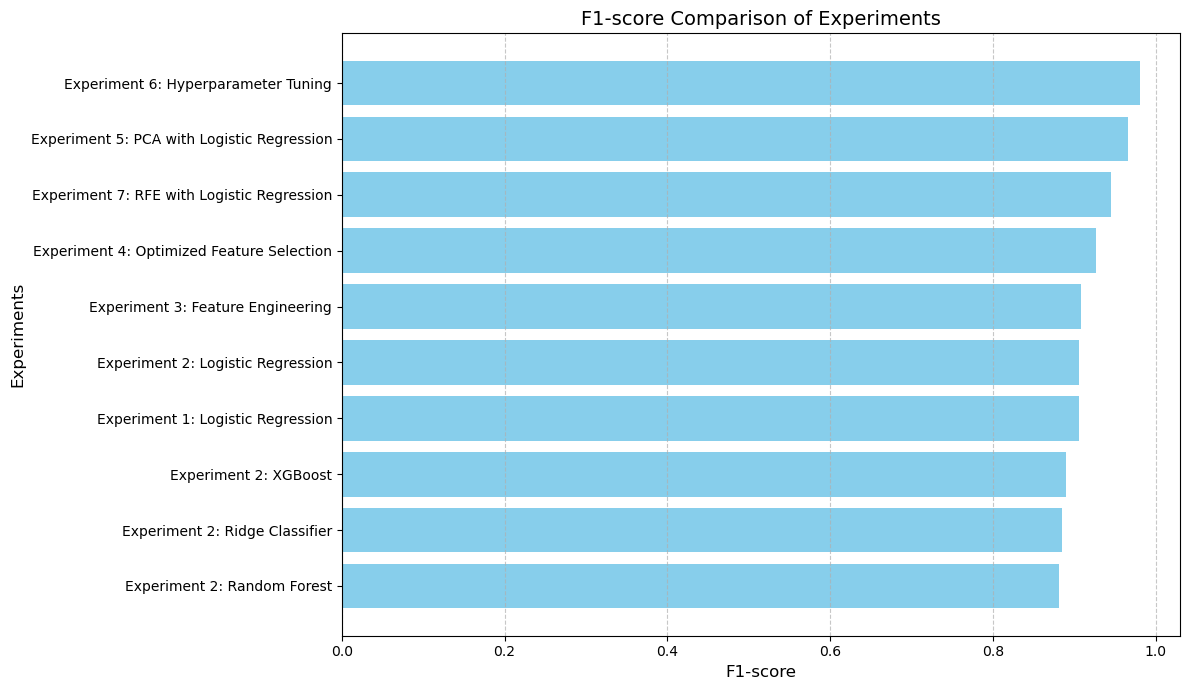

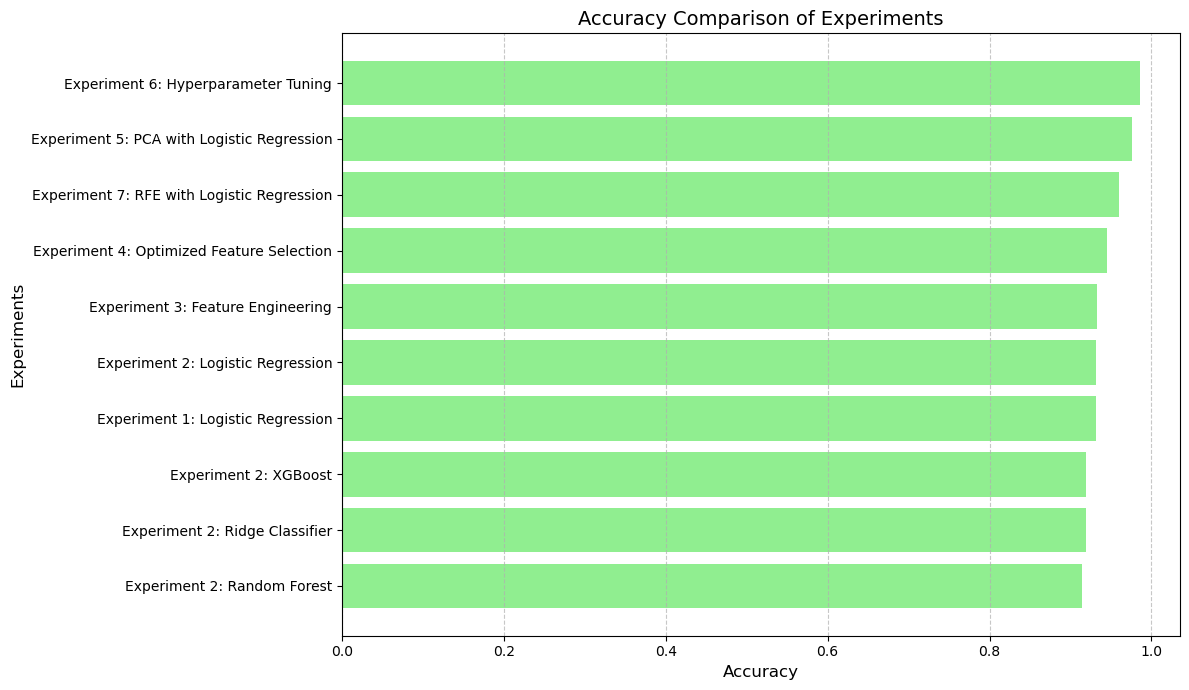

In [73]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

# Ensure inline plots in Jupyter Notebook
%matplotlib inline

# Set experiment name
experiment_name = "Machinelearning"  # Replace with your experiment name
experiment = mlflow.get_experiment_by_name(experiment_name)

if not experiment:
    print(f"Experiment '{experiment_name}' not found. Please check the name.")
else:
    experiment_id = experiment.experiment_id

    # Retrieve all runs for the experiment
    runs = mlflow.search_runs(experiment_ids=[experiment_id])

    # Debug: Print all columns to check available metrics and parameters
    print("Columns in the runs DataFrame:")
    print(runs.columns)

    # Select metrics of interest based on available metrics in your MLflow
    metrics_of_interest = ['f1_score', 'accuracy']  # Add or adjust as needed
    if not all([f'metrics.{m}' in runs.columns for m in metrics_of_interest]):
        print(f"Some metrics in {metrics_of_interest} are not found in the runs.")
    else:
        # Select and rename columns
        comparison_df = runs[['run_id', 'tags.mlflow.runName'] + [f'metrics.{m}' for m in metrics_of_interest]]
        comparison_df.rename(columns={
            'tags.mlflow.runName': 'run_name',
            'metrics.f1_score': 'f1_score',
            'metrics.accuracy': 'accuracy'
        }, inplace=True)

        # Drop rows without required metrics
        comparison_df.dropna(subset=['f1_score', 'accuracy'], inplace=True)

        if comparison_df.empty:
            print("No valid runs found with the required metrics.")
        else:
            # Print the comparison DataFrame
            print("Comparison of Experiments:")
            print(comparison_df[['run_name', 'f1_score', 'accuracy']])

            # Plot F1-score Comparison
            comparison_df.sort_values(by='f1_score', ascending=False, inplace=True)
            plt.figure(figsize=(12, 7))
            plt.barh(comparison_df['run_name'], comparison_df['f1_score'], color='skyblue')
            plt.xlabel('F1-score', fontsize=12)
            plt.ylabel('Experiments', fontsize=12)
            plt.title('F1-score Comparison of Experiments', fontsize=14)
            plt.gca().invert_yaxis()  # Show the best at the top
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('f1_score_comparison.png')
            plt.show()

            # Plot Accuracy Comparison
            comparison_df.sort_values(by='accuracy', ascending=False, inplace=True)
            plt.figure(figsize=(12, 7))
            plt.barh(comparison_df['run_name'], comparison_df['accuracy'], color='lightgreen')
            plt.xlabel('Accuracy', fontsize=12)
            plt.ylabel('Experiments', fontsize=12)
            plt.title('Accuracy Comparison of Experiments', fontsize=14)
            plt.gca().invert_yaxis()
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig('accuracy_comparison.png')
            plt.show()
